In [1]:
from pyspark.sql import SparkSession
import seaborn as sns

In [2]:
spark = SparkSession.builder.master('local[*]').appName('used-car-price').config('spark.executor.memory', '6g').getOrCreate()

24/09/08 14:26:29 WARN Utils: Your hostname, langchain resolves to a loopback address: 127.0.1.1; using 192.168.0.103 instead (on interface wlp3s0)
24/09/08 14:26:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/08 14:26:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
data_dir="data"
spark = SparkSession.builder.master('local[*]').appName('used-car-price')\
.config("spark.executor.instances", "1")\
.config("spark.executor.memory", "6g")\
.config("spark.driver.memory", "6g")\
.config("spark.executor.memoryOverhead", "8g")\
.getOrCreate()

24/09/08 14:26:31 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
spark.sparkContext._conf.getAll()

[('spark.app.submitTime', '1725819989807'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.app.id', 'local-1725819990673'),
 ('spark.driver.h

In [5]:
from pyspark.sql.functions import col, count, sum
csv_file_path = '../data/train.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)


In [6]:
df.show()

+---+-------------+--------------------+----------+------+-------------+--------------------+--------------------+--------------------+-------+--------------------+-----------+-----+
| id|        brand|               model|model_year|milage|    fuel_type|              engine|        transmission|             ext_col|int_col|            accident|clean_title|price|
+---+-------------+--------------------+----------+------+-------------+--------------------+--------------------+--------------------+-------+--------------------+-----------+-----+
|  0|         MINI|       Cooper S Base|      2007|213000|     Gasoline|172.0HP 1.6L 4 Cy...|                 A/T|              Yellow|   Gray|       None reported|        Yes| 4200|
|  1|      Lincoln|               LS V8|      2002|143250|     Gasoline|252.0HP 3.9L 8 Cy...|                 A/T|              Silver|  Beige|At least 1 accide...|        Yes| 4999|
|  2|    Chevrolet|   Silverado 2500 LT|      2002|136731|E85 Flex Fuel|320.0HP 5.3L 

**Brand & Model**: Identify the brand or company name along with the specific model of each vehicle. </br>
**Model Year**: Discover the manufacturing year of the vehicles, crucial for assessing depreciation and technology advancements. </br>
**Mileage**: Obtain the mileage of each vehicle, a key indicator of wear and tear and potential maintenance requirements.  </br>
**Fuel Type**: Learn about the type of fuel the vehicles run on, whether it's gasoline, diesel, electric, or hybrid.  </br>
**Engine Type**: Understand the engine specifications, shedding light on performance and efficiency.  </br>
**Transmission**: Determine the transmission type, whether automatic, manual, or another variant.  </br>
**Exterior & Interior Colors**: Explore the aesthetic aspects of the vehicles, including exterior and interior color options.  </br>
**Accident History**: Discover whether a vehicle has a prior history of accidents or damage, crucial for informed decision-making.  </br>
**Clean Title**: Evaluate the availability of a clean title, which can impact the vehicle's resale value and legal status.  </br>
**Price**: Access the listed prices for each vehicle, aiding in price comparison and budgeting.  </br>

In [7]:
from pyspark.sql.types import NumericType,StringType

# List of numerical columns
numerical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]

#list of string columns
categorical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]

print(numerical_columns)
print(categorical_columns)

['id', 'model_year', 'milage', 'price']
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


#describing the numerical features

In [8]:
for feature in numerical_columns:
    if feature not in ['id','model_year']: 
        df.select(feature).describe().show()


+-------+-----------------+
|summary|           milage|
+-------+-----------------+
|  count|           188533|
|   mean| 65705.2951737892|
| stddev|49798.15807575404|
|    min|              100|
|    max|           405000|
+-------+-----------------+

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|           188533|
|   mean|43878.01617753921|
| stddev|78819.52225446468|
|    min|             2000|
|    max|          2954083|
+-------+-----------------+



null counts

In [9]:
from pyspark.sql.functions import col, sum as sql_sum
null_counts = df.select([sql_sum(col(c).isNull().cast("integer")).alias(c) for c in df.columns])
null_counts.show()


+---+-----+-----+----------+------+---------+------+------------+-------+-------+--------+-----------+-----+
| id|brand|model|model_year|milage|fuel_type|engine|transmission|ext_col|int_col|accident|clean_title|price|
+---+-----+-----+----------+------+---------+------+------------+-------+-------+--------+-----------+-----+
|  0|    0|    0|         0|     0|     5083|     0|           0|      0|      0|    2452|      21419|    0|
+---+-----+-----+----------+------+---------+------+------------+-------+-------+--------+-----------+-----+



shape of data

In [10]:
rows = df.count()
columns = len(df.columns)

In [11]:
rows,columns

(188533, 13)

median price of cars based on model_year

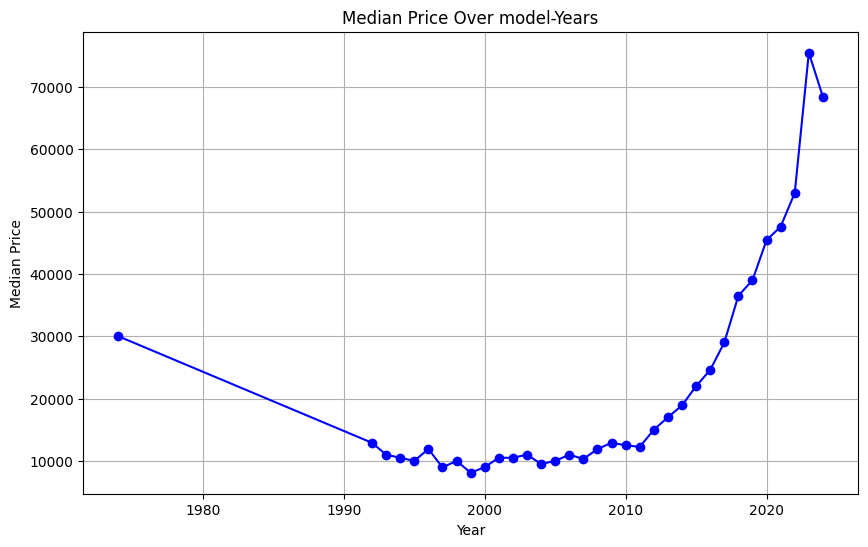

In [12]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

median_price_df = df.groupBy('model_year').agg(F.expr('percentile_approx(price, 0.5)').alias('median_price'))
median_price_pdf = median_price_df.toPandas()
median_price_pdf = median_price_pdf.sort_values(by='model_year')

plt.figure(figsize=(10, 6))
plt.plot(median_price_pdf['model_year'], median_price_pdf['median_price'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Median Price')
plt.title('Median Price Over model-Years')
plt.grid(True)
plt.show()


the line graph shows with the latest model-year used vehicles their price is also increases, that means their cost where also more

unique values in transmission

In [13]:
transmission_un = df.select('transmission').distinct().orderBy('transmission')
transmission_un.show()


+--------------------+
|        transmission|
+--------------------+
|         1-Speed A/T|
|   1-Speed Automatic|
|        10-Speed A/T|
|  10-Speed Automatic|
|10-Speed Automati...|
|                   2|
|         2-Speed A/T|
|   2-Speed Automatic|
|         4-Speed A/T|
|   4-Speed Automatic|
|         5-Speed A/T|
|   5-Speed Automatic|
|         5-Speed M/T|
|       6 Speed At/Mt|
|          6 Speed Mt|
|             6-Speed|
|         6-Speed A/T|
|   6-Speed Automatic|
|6-Speed Automatic...|
|6-Speed Electroni...|
+--------------------+
only showing top 20 rows



A/T , automatic are same and M/T is manual 

In [14]:
df.select("transmission").distinct().count()


52

In [15]:
transmission_counts = df.groupBy('transmission').agg(count('transmission').alias('count')).orderBy('count')
transmission_counts.show(n=52)

+--------------------+-----+
|        transmission|count|
+--------------------+-----+
|SCHEDULED FOR OR ...|    6|
|         8-SPEED A/T|    7|
|          8-SPEED AT|   13|
|               CVT-F|   15|
|Single-Speed Fixe...|   16|
|7-Speed DCT Autom...|   18|
|       6 Speed At/Mt|   20|
|   2-Speed Automatic|   22|
|              Manual|   27|
|             6-Speed|   27|
|      8-Speed Manual|   28|
|             7-Speed|   29|
|6-Speed Electroni...|   31|
|9-Speed Automatic...|   33|
|          6 Speed Mt|   37|
|10-Speed Automati...|   40|
|   4-Speed Automatic|   48|
|                   F|   65|
|            Variable|   66|
|         2-Speed A/T|   71|
|                   –|   87|
|                   2|   91|
|6-Speed Automatic...|  111|
|      7-Speed Manual|  151|
|Transmission Over...|  156|
|   5-Speed Automatic|  159|
|   7-Speed Automatic|  178|
|      6-Speed Manual|  211|
|         7-Speed M/T|  355|
|   1-Speed Automatic|  365|
|8-Speed Automatic...|  549|
|       Automa

there are 52 unique values in transmission 

Continuously Variable Transmission (CVT)

In [16]:
# Grouping by Transmission and calculating the median price
med_price_df = df.groupBy('Transmission').agg(F.expr('percentile_approx(price, 0.5)').alias('median_price'))
med_price_df.show()

+--------------------+------------+
|        Transmission|median_price|
+--------------------+------------+
|SCHEDULED FOR OR ...|       35645|
|    CVT Transmission|       20999|
|8-Speed Automatic...|       99950|
|Transmission Over...|       23500|
|                   F|       33998|
|          6 Speed Mt|       36598|
|7-Speed Automatic...|       67963|
|      7-Speed Manual|      116911|
|6-Speed Electroni...|       28748|
|               CVT-F|       27785|
|         2-Speed A/T|       54500|
|   6-Speed Automatic|       29998|
|9-Speed Automatic...|       78500|
|           Automatic|       44998|
|      8-Speed Manual|       84645|
|                 A/T|       20500|
|   1-Speed Automatic|       46552|
|   9-Speed Automatic|       40995|
|                   –|       94500|
|         4-Speed A/T|       10000|
+--------------------+------------+
only showing top 20 rows



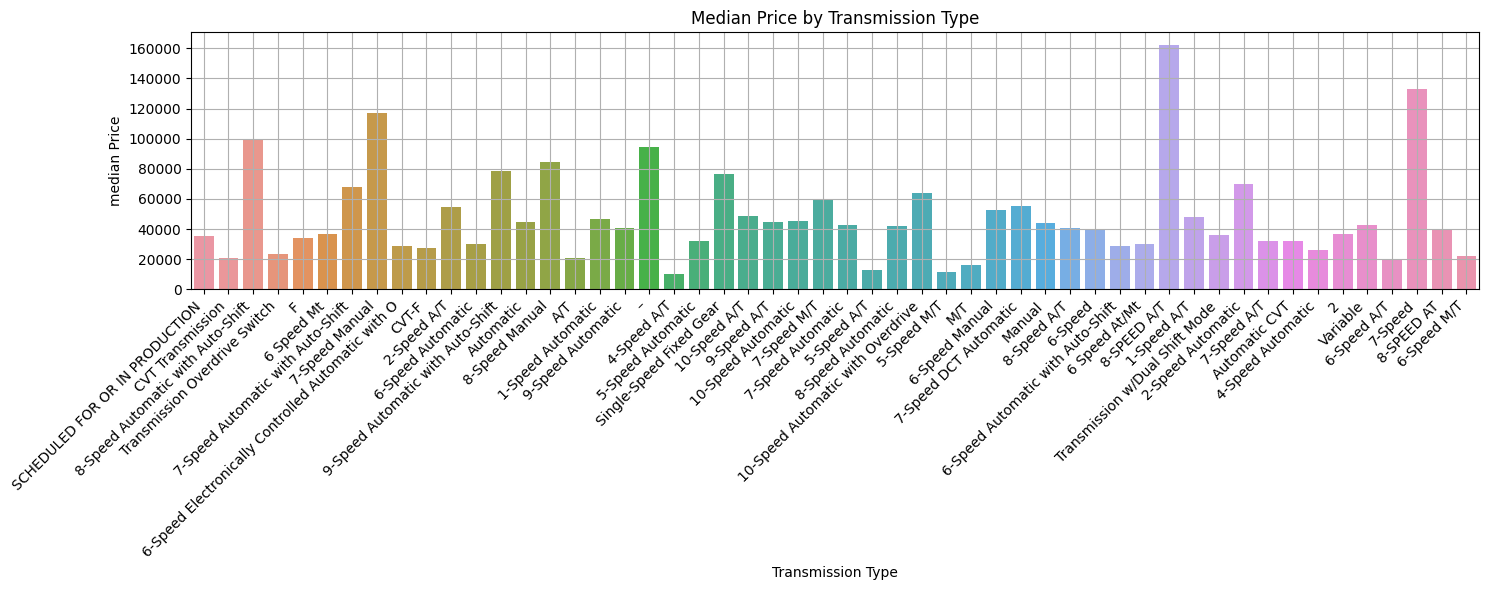

In [17]:
med_price_pdf = med_price_df.toPandas()
plt.figure(figsize=(15, 6)) 
sns.barplot(x='Transmission', y='median_price', data=med_price_pdf)
plt.xlabel('Transmission Type')
plt.ylabel('median Price')
plt.title('Median Price by Transmission Type')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.grid(True)
plt.show()

median price by transmission shows that 7, 8 speed automatic vehicles have highest price in even in second hand

In [18]:
brand_un = df.select('brand').distinct().orderBy('brand')
brand_un.show()

+---------+
|    brand|
+---------+
|    Acura|
|     Alfa|
|    Aston|
|     Audi|
|      BMW|
|  Bentley|
|  Bugatti|
|    Buick|
| Cadillac|
|Chevrolet|
| Chrysler|
|    Dodge|
|     FIAT|
|  Ferrari|
|     Ford|
|      GMC|
|  Genesis|
|    Honda|
|   Hummer|
|  Hyundai|
+---------+
only showing top 20 rows



In [19]:
df.select("brand").distinct().count()

57

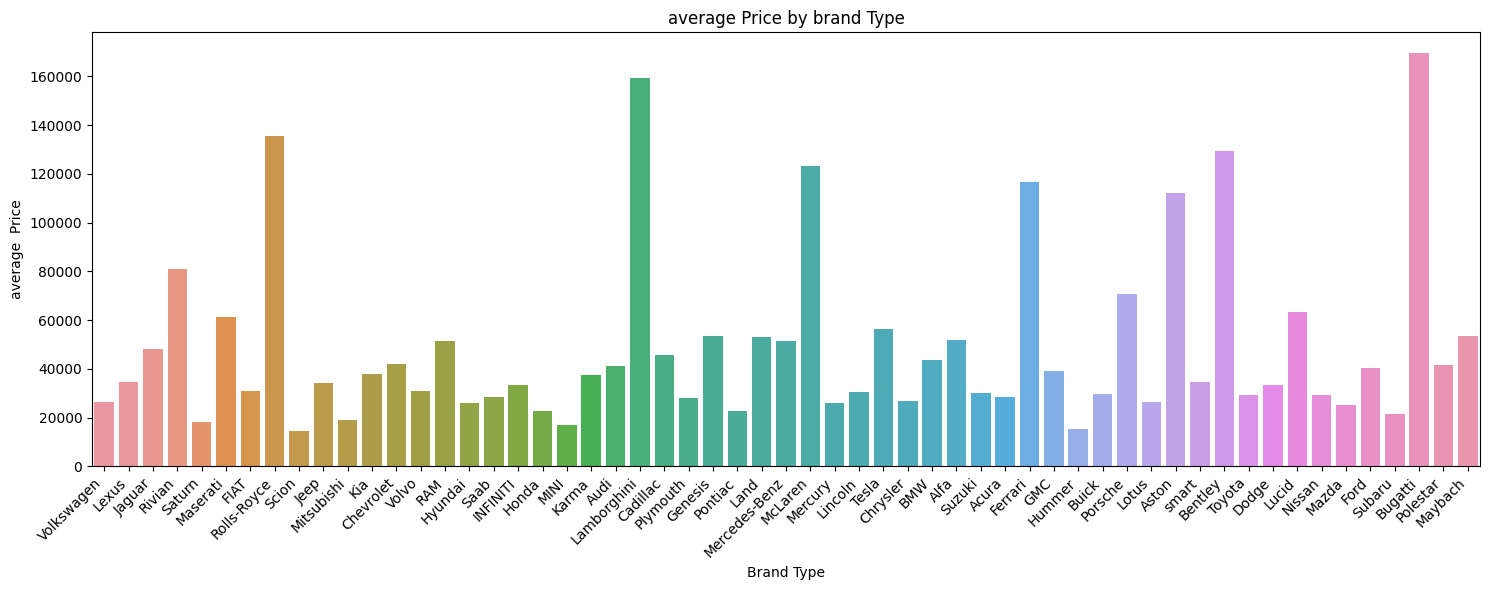

In [20]:
avg_price_df = df.groupBy('brand').agg(F.mean('price').alias('avg_price'))
avg_price_pdf = avg_price_df.toPandas()

plt.figure(figsize=(15, 6)) 
sns.barplot(x='brand', y='avg_price', data=avg_price_pdf)
plt.xlabel('Brand Type')
plt.ylabel('average  Price')
plt.title('average Price by brand Type')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()



the car brand like Rolls-Royce,Lamborghini, McLaren, Ferrari, Bentley,Aston and Bugati in average has highest price

In [21]:
df.select('accident').distinct().show()

+--------------------+
|            accident|
+--------------------+
|At least 1 accide...|
|       None reported|
|                NULL|
+--------------------+



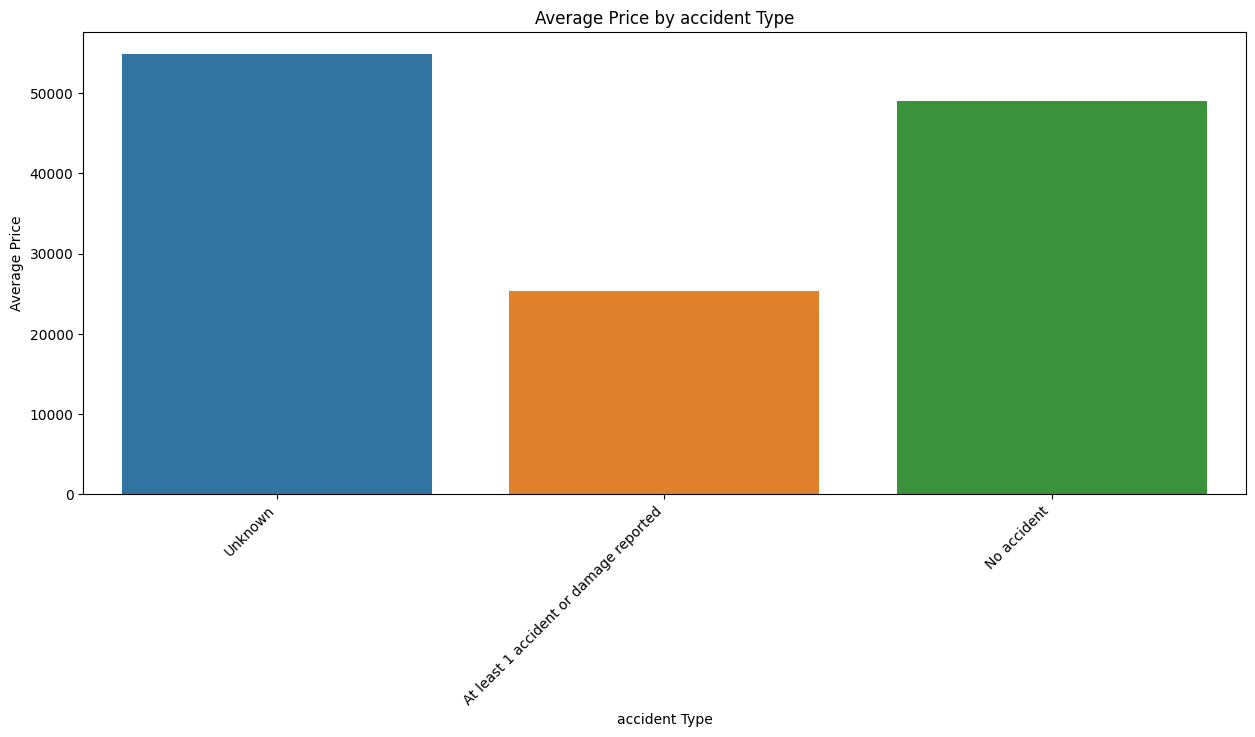

In [22]:
avg_price_incident_df = df.groupBy('accident').agg(F.mean('price').alias('avg_price'))
avg_price_incident_pdf = avg_price_incident_df.toPandas()
# Clean the accident column to handle any null or 'None' values and None reported with no accident
avg_price_incident_pdf['accident'] = avg_price_incident_pdf['accident'].fillna('Unknown').replace('None reported', 'No accident')
plt.figure(figsize=(15, 6))
sns.barplot(x='accident', y='avg_price', data=avg_price_incident_pdf)
plt.xlabel('accident Type')
plt.ylabel('Average Price')
plt.title('Average Price by accident Type')
plt.xticks(rotation=45, ha='right')

plt.show()

This graph shows that if a car is having damage reported and an accident then it's price will decrease.

In [23]:
df.select('fuel_type').distinct().show()

+--------------+
|     fuel_type|
+--------------+
|      Gasoline|
| E85 Flex Fuel|
|        Diesel|
|             –|
|        Hybrid|
|Plug-In Hybrid|
| not supported|
|          NULL|
+--------------+



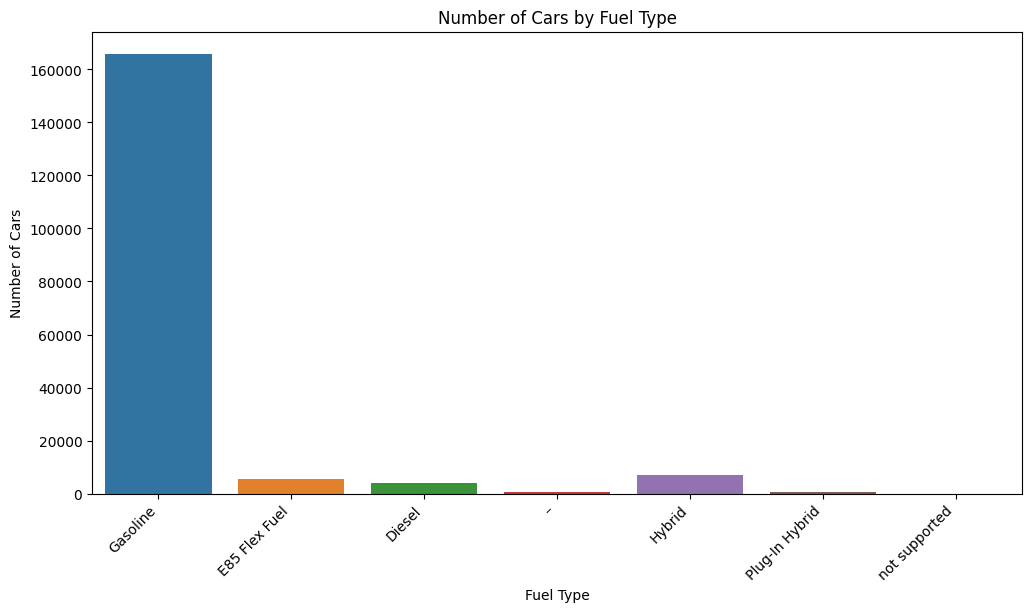

In [24]:
fuel_type_count_df = df.groupBy('fuel_type').count()
fuel_type_count_pdf = fuel_type_count_df.toPandas()
plt.figure(figsize=(12, 6))

sns.barplot(x='fuel_type', y='count', data=fuel_type_count_pdf)
plt.xlabel('Fuel Type')
plt.ylabel('Number of Cars')
plt.title('Number of Cars by Fuel Type')

plt.xticks(rotation=45, ha='right')

plt.show()

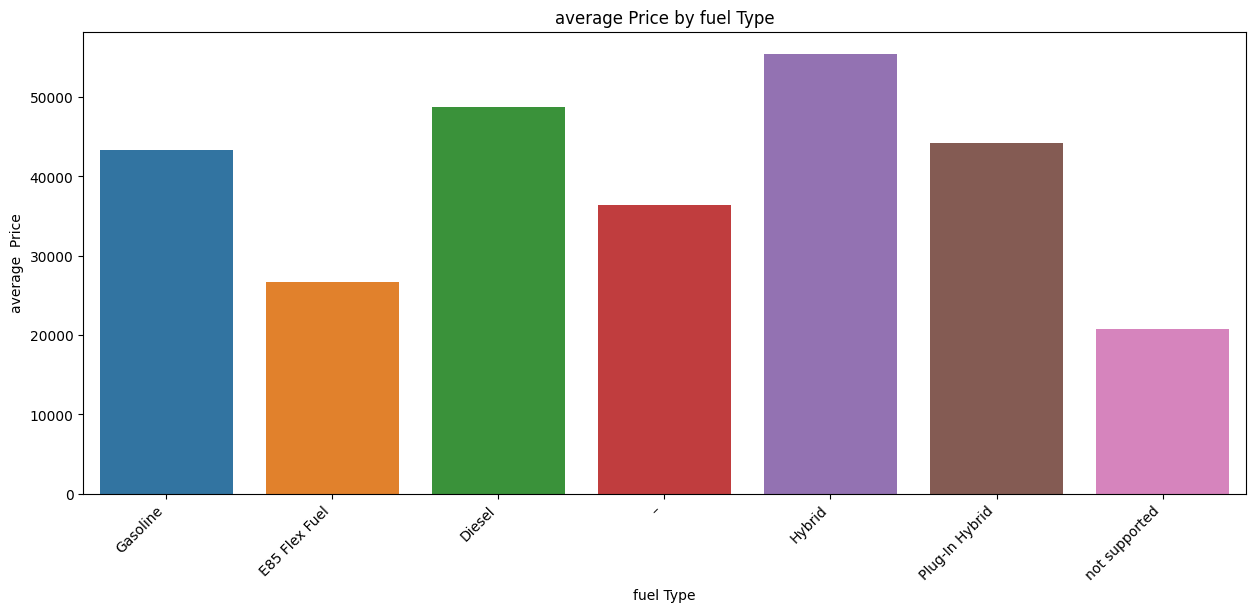

In [25]:
avg_price_df = df.groupBy('fuel_type').agg(F.mean('price').alias('avg_price'))
# Convert to Pandas DataFrame for plotting
avg_price_pdf = avg_price_df.toPandas()

plt.figure(figsize=(15, 6)) 
sns.barplot(x='fuel_type', y='avg_price', data=avg_price_pdf)

plt.xlabel('fuel Type')
plt.ylabel('average  Price')
plt.title('average Price by fuel Type')
plt.xticks(rotation=45, ha='right')  

plt.show()

the two graph shows that gasoline vehiles are mostly used because in an average it's cost is lower than diesel and Hybrid car

In [26]:
from pyspark.sql.functions import desc


avg_price_brand_year_df = df.groupBy('brand', 'model_year') \
    .agg(F.mean('price').alias('avg_price')) \
    .orderBy(F.col('model_year').desc())

avg_price_brand_year_pdf = avg_price_brand_year_df.toPandas()

avg_price_brand_year_pdf

,brand,model_year,avg_price
0,Acura,2024,99694.333333
1,Lexus,2024,52015.666667
2,RAM,2024,51750.000000
3,Toyota,2024,51812.375000
4,BMW,2024,82521.029412
...,...,...,...
1342,Ford,1974,72441.857143
1343,Porsche,1974,29000.000000
1344,Jaguar,1974,115998.000000
1345,Lincoln,1974,9999.000000


top 10 ext_colors used in car based on their average price

In [27]:
top_10_colors_df = df.groupBy('ext_col').agg(F.mean('price').alias('avg_price')).orderBy(F.desc('avg_price')).limit(10)
top_10_colors_pdf = top_10_colors_df.toPandas()
top_10_colors_pdf

,ext_col,avg_price
0,Blue Caelum,396263.600000
1,Dark Sapphire,355541.454545
2,Bianco Monocerus,300063.076923
3,C / C,292528.088235
4,Ice,288203.272727
5,Tempest,261495.750000
6,Beluga Black,222964.363636
7,Bianco Icarus Metallic,221547.277778
8,GT SILVER,214287.200000
9,BLU ELEOS,206435.000000


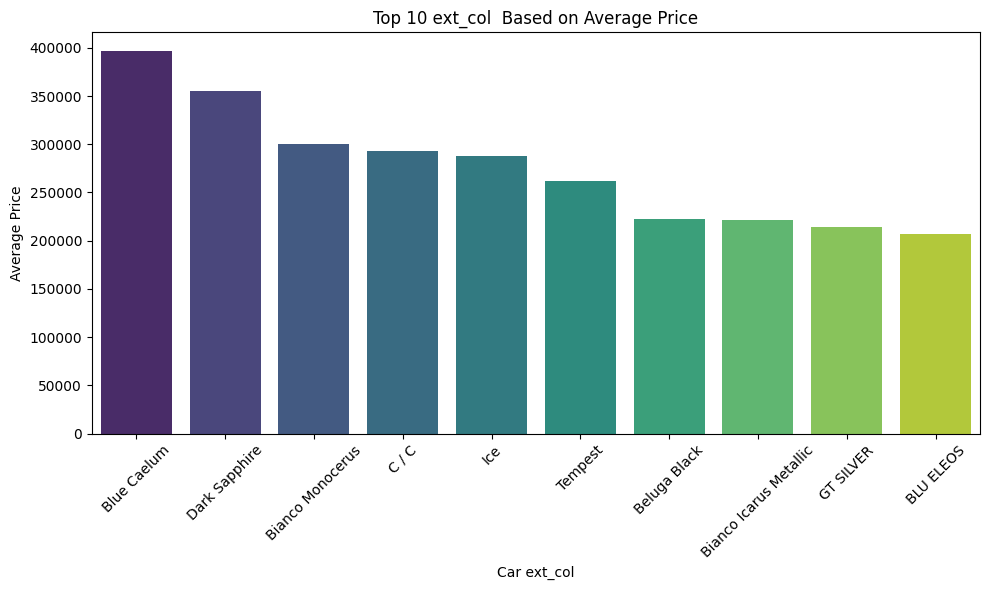

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x='ext_col', y='avg_price', data=top_10_colors_pdf, palette='viridis')

plt.xlabel('Car ext_col')
plt.ylabel('Average Price')
plt.title('Top 10 ext_col  Based on Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In an average the price of car having color Blue Caelum is greater

In [29]:
top_10_int_df = df.groupBy('int_col').agg(F.mean('price').alias('avg_price')).orderBy(F.desc('avg_price')).limit(10)
top_10_int_pdf = top_10_int_df.toPandas()
top_10_int_pdf

,int_col,avg_price
0,Dark Auburn,268591.333333
1,Hotspur,257780.844444
2,Cobalt Blue,249600.666667
3,Beluga Hide,233563.625000
4,Linen,224166.555556
5,Beluga,205607.200000
6,Black / Brown,203085.638889
7,Nero Ade,186171.642674
8,Sahara Tan,182831.516129
9,Portland,174865.392157


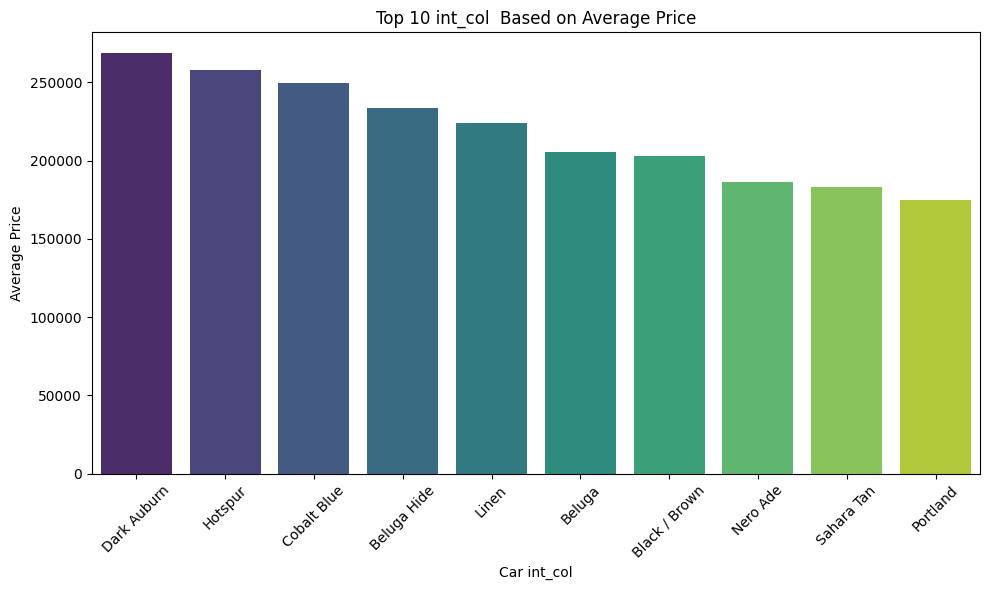

In [30]:
top_10_int_df = df.groupBy('int_col').agg(F.mean('price').alias('avg_price')).orderBy(F.desc('avg_price')).limit(10)
top_10_int_pdf = top_10_int_df.toPandas()
top_10_int_pdf

plt.figure(figsize=(10, 6))
sns.barplot(x='int_col', y='avg_price', data=top_10_int_pdf, palette='viridis')

plt.xlabel('Car int_col')
plt.ylabel('Average Price')
plt.title('Top 10 int_col  Based on Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

average mileage based on model-year

In [31]:
avg_mileage_by_year_df = df.groupBy('model_year').agg(F.mean('milage').alias('avg_milage'))
avg_mileage_by_year_pdf = avg_mileage_by_year_df.toPandas().sort_values('avg_milage',ascending = False)
avg_mileage_by_year_pdf.head(5)

,model_year,avg_milage
30,1999,134483.140794
25,2000,132044.431900
13,2004,131982.563813
9,1997,128988.118590
24,2005,121495.681687


/home/lang_chain/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lang_chain/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


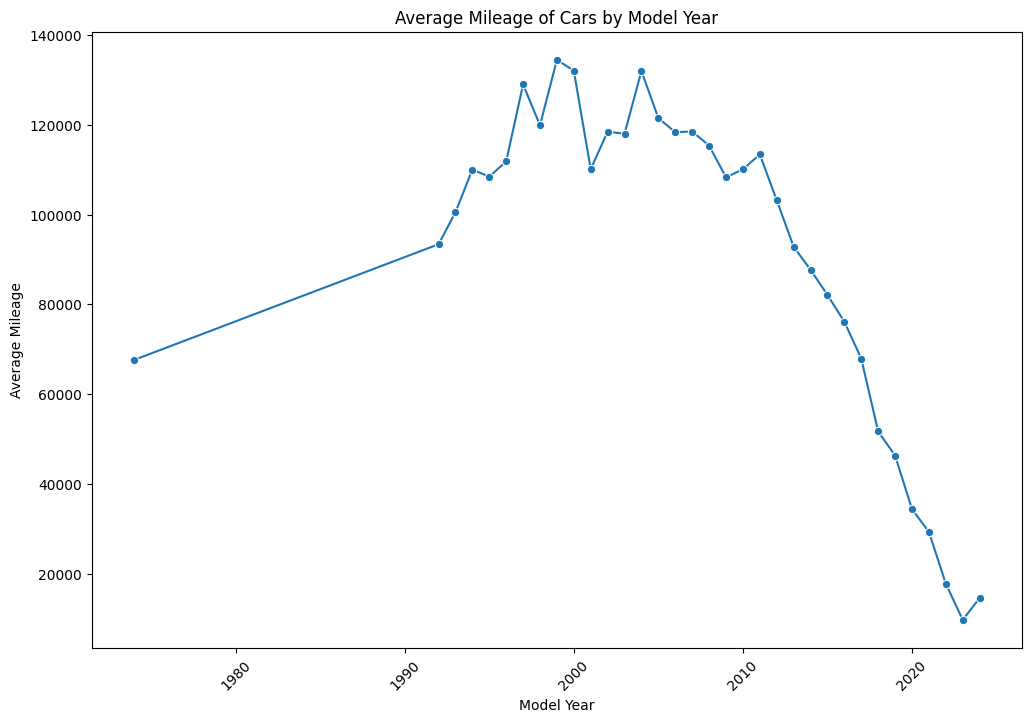

In [32]:

plt.figure(figsize=(12, 8))

sns.lineplot(x='model_year', y='avg_milage', data=avg_mileage_by_year_pdf, marker='o')

plt.xlabel('Model Year')
plt.ylabel('Average Mileage')
plt.title('Average Mileage of Cars by Model Year')

plt.xticks(rotation=45)

plt.show()


In an average the mileage of old car is greater then new current cars

In [33]:
numerical_data = sorted(numerical_columns)  

# Melting the df
f = df.selectExpr("stack({0}, {1}) as (variable, value)".format(
    len(numerical_data),
    ", ".join(f"'{col}', {col}" for col in numerical_data)
))

/home/lang_chain/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lang_chain/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lang_chain/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lang_chain/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

<Figure size 1500x1000 with 0 Axes>

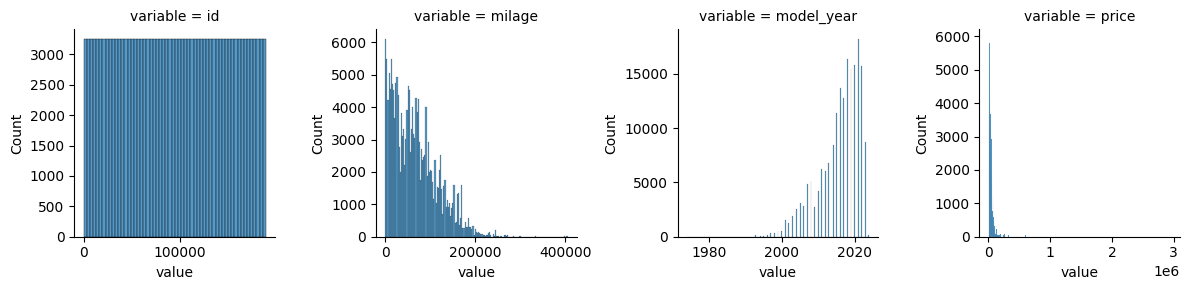

In [34]:
pandas_df = f.toPandas()
plt.figure(figsize=(15, 10))
g = sns.FacetGrid(pandas_df, col='variable', col_wrap=4, sharex=False, sharey=False)
g.map(sns.histplot, 'value')
plt.show()


/home/lang_chain/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


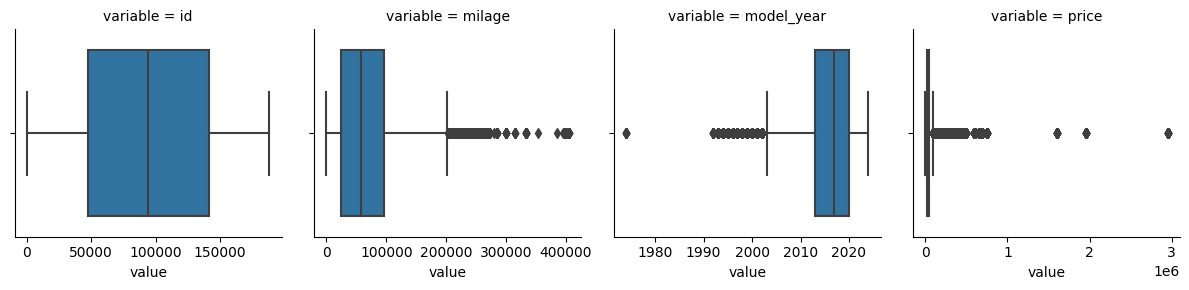

In [35]:
g_box = sns.FacetGrid(pandas_df, col='variable', col_wrap=4, sharex=False, sharey=False)
g_box.map(sns.boxplot, 'value')
plt.subplots_adjust(hspace=0.4)  

plt.show()

there is presence of outliers in milage and price 

In [36]:
from pyspark.sql.functions import col, when, avg,median,count
for col_name in numerical_columns:
    null_count = df.filter(col(col_name).isNull()).count()
    if null_count > 0:
        print(f"Column '{col_name}' has {null_count} null values.")

In [37]:
for col_name in categorical_columns:
    null_count = df.filter(col(col_name).isNull()).count()
    if null_count > 0:
        print(f"Column '{col_name}' has {null_count} null values.")

Column 'fuel_type' has 5083 null values.
Column 'accident' has 2452 null values.
Column 'clean_title' has 21419 null values.


In [38]:
categorical_columns_with_nan = ['fuel_type','accident','clean_title']

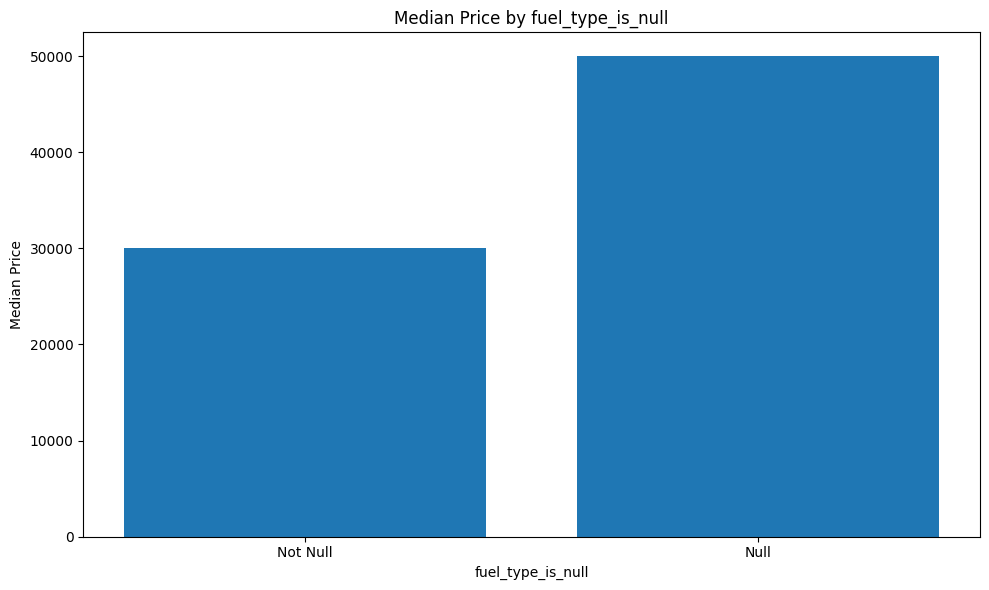

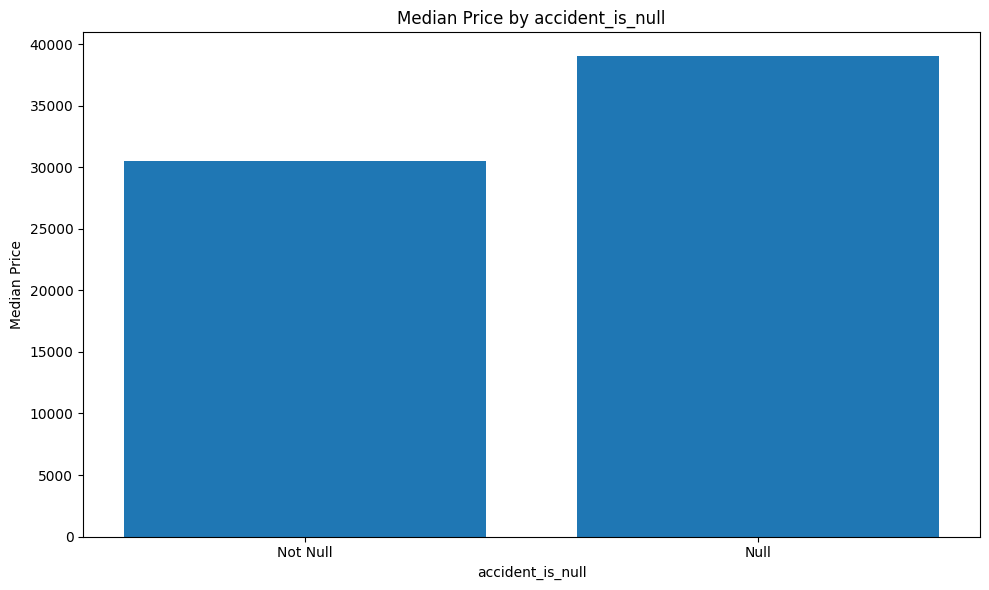

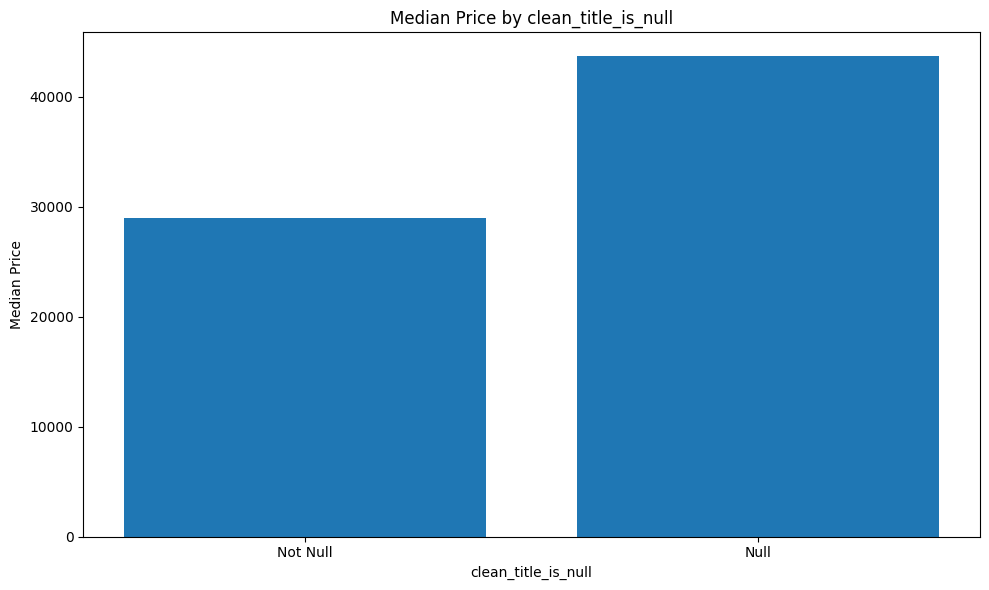

In [39]:
for feature in categorical_columns_with_nan:
    df_with_indicator = df.withColumn(f'{feature}_is_null', when(col(feature).isNull(), 1).otherwise(0))
    median_price_df = df_with_indicator.groupBy(f'{feature}_is_null').agg(median('price').alias('median_price'))
    median_price_pdf = median_price_df.toPandas()
    
    plt.figure(figsize=(10, 6))
    plt.bar(median_price_pdf[f'{feature}_is_null'], median_price_pdf['median_price'])
    plt.xlabel(f'{feature}_is_null')
    plt.ylabel('Median Price')
    plt.title(f'Median Price by {feature}_is_null')
    plt.xticks([0, 1], ['Not Null', 'Null'])
    plt.tight_layout()
    plt.show()

The median price of null values is greater in columns with null values, it can indicate that the presence of nulls is correlated with higher prices. This could suggest that missing data in these columns might be meaningful or related to certain segments of your data.

identifying rare categorical feature

In [40]:
categorical_columns

['brand',
 'model',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title']

In [41]:
threshold = 2  

for feature in categorical_columns:
    feature_counts = df.groupBy(feature).agg(count('*').alias('count'))

    rare_features = feature_counts.filter(col('count') < threshold)

    rare_features_list = rare_features.collect()
    if rare_features_list:
        print(f"Rare features in '{feature}':")
        for row in rare_features_list:
            print(f"Value: {row[feature]}, Count: {row['count']}")
    else:
        print(f"No rare features found in '{feature}'.")

No rare features found in 'brand'.
Rare features in 'model':
Value: X5 3.0i, Count: 1
Value: X5 xDrive40e, Count: 1
Value: XLR Base, Count: 1
Value: Integra w/A-Spec Tech Package, Count: 1
No rare features found in 'fuel_type'.
Rare features in 'engine':
Value: 70.0HP 1.0L 3 Cylinder Engine Gasoline Fuel, Count: 1
Value: 443.0HP 4.4L 8 Cylinder Engine Gasoline Fuel, Count: 1
Value: 111.0HP Electric Motor Electric Fuel System, Count: 1
Value: 184.0HP 2.4L 4 Cylinder Engine Flex Fuel Capability, Count: 1
Value: 151.0HP 1.5L 4 Cylinder Engine Gas/Electric Hybrid, Count: 1
Value: 139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas, Count: 1
Value: 78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel, Count: 1
Value: 313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas, Count: 1
No rare features found in 'transmission'.
No rare features found in 'ext_col'.
No rare features found in 'int_col'.
No rare features found in 'accident'.
No rare features found in 'clean_title'.


there are rare features in Model, engine

correlation test

In [43]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
vector_df = assembler.transform(df).select("features")
correlation_matrix = Correlation.corr(vector_df, "features").head()[0]
correlation_matrix_np = correlation_matrix.toArray()
correlation_df = pd.DataFrame(correlation_matrix_np, columns=numerical_columns, index=numerical_columns)
print(correlation_df)

                  id  model_year    milage     price
id          1.000000    0.000076 -0.001834 -0.000877
model_year  0.000076    1.000000 -0.669936  0.231795
milage     -0.001834   -0.669936  1.000000 -0.283067
price      -0.000877    0.231795 -0.283067  1.000000


model_year and milage: </br>

Correlation: -0.669936 </br>
Interpretation: There is a strong negative correlation between model_year and milage. This indicates that as the model_year increases (i.e., newer cars), the milage tends to decrease. This is expected because newer cars typically have lower mileage.
</br>

model_year and price:</br>

Correlation: 0.231795 </br>
Interpretation: There is a weak positive correlation between model_year and price. This suggests that while newer models might have a slight tendency to be more expensive, the relationship is not very strong. Other factors likely influence the price more significantly. </br>

milage and price:</br>

Correlation: -0.283067 </br>
Interpretation: There is a weak negative correlation between milage and price. This means that as milage increases, the price tends to decrease slightly. Higher mileage is often associated with lower prices, but this relationship is weak, indicating that price is influenced by factors other than just mileage.

**Summary** </br>
model_year vs. milage: Strong negative correlation indicates that newer cars usually have lower mileage. </br>
model_year vs. price: Weak positive correlation suggests that newer cars are somewhat more expensive, but this relationship is not strong. </br>
milage vs. price: Weak negative correlation shows that higher mileage cars tend to have lower prices, but the effect is not strong. </br>

</br>
These insights can guide further analysis and feature selection for predictive modeling. For instance, model_year and milage are likely to be significant features in predicting price, but their relationships with price might need to be explored in conjunction with other variables for a more comprehensive model.

checking the duplicate records

In [44]:
duplicates_df = (df
    .groupBy(df.columns)  
    .agg(F.count('*').alias('count'))
    .filter(F.col('count') > 1)
)
duplicates_df.show()

+---+-----+-----+----------+------+---------+------+------------+-------+-------+--------+-----------+-----+-----+
| id|brand|model|model_year|milage|fuel_type|engine|transmission|ext_col|int_col|accident|clean_title|price|count|
+---+-----+-----+----------+------+---------+------+------------+-------+-------+--------+-----------+-----+-----+
+---+-----+-----+----------+------+---------+------+------------+-------+-------+--------+-----------+-----+-----+



no duplicate data recorded

In [45]:
from fuzzywuzzy import process, fuzz
from pyspark.sql import functions as F


unique_transmissions = [row['transmission'] for row in transmission_counts.select('transmission').distinct().collect()]

def find_similar(value, choices, threshold=80):
    return process.extractOne(value, choices, scorer=fuzz.token_sort_ratio)[0] if process.extractOne(value, choices, scorer=fuzz.token_sort_ratio)[1] >= threshold else value

standardized_map = {value: find_similar(value, unique_transmissions) for value in unique_transmissions}


/media/lang_chain/Storage/azure-code/.conda/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [46]:
model_counts = df.groupBy('model').agg(count('model').alias('count')).orderBy('count')
model_counts.show(n=52)

+--------------------+-----+
|               model|count|
+--------------------+-----+
|             X5 3.0i|    1|
|        X5 xDrive40e|    1|
|            XLR Base|    1|
|Integra w/A-Spec ...|    1|
|            Forte LX|    2|
|         ForTwo Pure|    2|
|X5 xDrive 35i Spo...|    2|
|V60 T6 R-Design P...|    2|
|            X5 3.0si|    2|
|               XLR V|    2|
|        X3 xDrive35i|    2|
|IONIQ Plug-In Hyb...|    2|
|Sportage Plug-In ...|    3|
| X5 eDrive xDrive40e|    3|
|740e xDrive iPerf...|    3|
|Ascent Limited 7-...|    3|
|500e Battery Elec...|    3|
|          Stinger GT|    3|
|          370Z NISMO|    3|
|            XC60 3.2|    3|
|          Insight EX|    3|
|       Corvette ZR-1|    3|
|             i3 Base|    4|
|            3500 SLT|    4|
|        X6 sDrive35i|    4|
|          Yaris Base|    4|
|        Type 57 Base|    4|
|C-Class 4MATIC Sedan|    4|
|     Ram 1500 SRT-10|    4|
|     Impreza Premium|    4|
|               Rio S|    4|
|allroad 2.0T 

In [47]:
engine_counts = df.groupBy('engine').agg(count('engine').alias('count')).orderBy('count') 
engine_counts.show(n=52)

+--------------------+-----+
|              engine|count|
+--------------------+-----+
|70.0HP 1.0L 3 Cyl...|    1|
|443.0HP 4.4L 8 Cy...|    1|
|111.0HP Electric ...|    1|
|184.0HP 2.4L 4 Cy...|    1|
|151.0HP 1.5L 4 Cy...|    1|
|139.0HP 1.6L 4 Cy...|    1|
|78.0HP 1.2L 3 Cyl...|    1|
|313.0HP 2.0L 4 Cy...|    1|
|141.0HP 2.0L 4 Cy...|    2|
|543.0HP 5.5L 12 C...|    2|
|322.0HP 2.0L 4 Cy...|    2|
|139.0HP 1.6L 4 Cy...|    2|
|3.8L V6 12V MPFI OHV|    2|
|250.0HP 2.7L V6 C...|    2|
|192.0HP 2.0L 4 Cy...|    3|
|121.0HP 1.8L 4 Cy...|    3|
|226.0HP 1.6L 4 Cy...|    3|
|115.0HP Electric ...|    3|
|           1.8 Liter|    4|
|332.0HP 6.0L 8 Cy...|    4|
|260.0HP 3.0L Stra...|    4|
|120.0HP 2.2L 4 Cy...|    4|
|              120 AH|    4|
|567.0HP 6.0L 12 C...|    4|
|266.0HP 2.5L 4 Cy...|    4|
|178.0HP 1.8L 4 Cy...|    4|
|4.4 Liter GDI DOH...|    4|
|280.0HP 2.8L V6 C...|    4|
|164.0HP 1.4L 4 Cy...|    4|
|1.6L I4 16V GDI DOHC|    4|
|212.0HP 1.5L 4 Cy...|    4|
|180.0HP 6.5L 

In [48]:
engine_counts = df.groupBy('engine').agg(count('engine').alias('count')).orderBy(F.col('count').desc())
engine_counts.show(n=52)

+--------------------+-----+
|              engine|count|
+--------------------+-----+
|355.0HP 5.3L 8 Cy...| 3462|
|240.0HP 2.0L 4 Cy...| 2902|
|420.0HP 6.2L 8 Cy...| 2841|
|2.0L I4 16V GDI D...| 2680|
|375.0HP 3.5L V6 C...| 2451|
|340.0HP 3.0L V6 C...| 2436|
|490.0HP 6.2L 8 Cy...| 2187|
|455.0HP 6.2L 8 Cy...| 2138|
|425.0HP 3.0L Stra...| 2134|
|300.0HP 3.0L Stra...| 2084|
|295.0HP 3.5L V6 C...| 1917|
|285.0HP 3.6L V6 C...| 1910|
|302.0HP 3.5L V6 C...| 1895|
|3.5L V6 24V PDI D...| 1842|
|301.0HP 4.6L 8 Cy...| 1578|
|5.7L V8 16V MPFI OHV| 1540|
|4.0L V8 32V GDI D...| 1516|
|3.6L V6 24V MPFI ...| 1480|
|268.0HP 3.5L V6 C...| 1470|
|333.0HP 3.0L V6 C...| 1319|
|365.0HP 3.5L V6 C...| 1275|
|211.0HP 2.0L 4 Cy...| 1234|
|3.6L V6 24V GDI DOHC| 1224|
|     2.0 Liter Turbo| 1164|
|210.0HP 3.7L V6 C...| 1132|
|252.0HP 2.0L 4 Cy...| 1120|
|248.0HP 2.0L 4 Cy...| 1080|
|255.0HP 2.0L 4 Cy...| 1054|
|380.0HP 3.0L V6 C...| 1027|
|381.0HP 5.7L 8 Cy...| 1012|
| 5.3L V8 16V GDI OHV| 1011|
|335.0HP 3.0L 

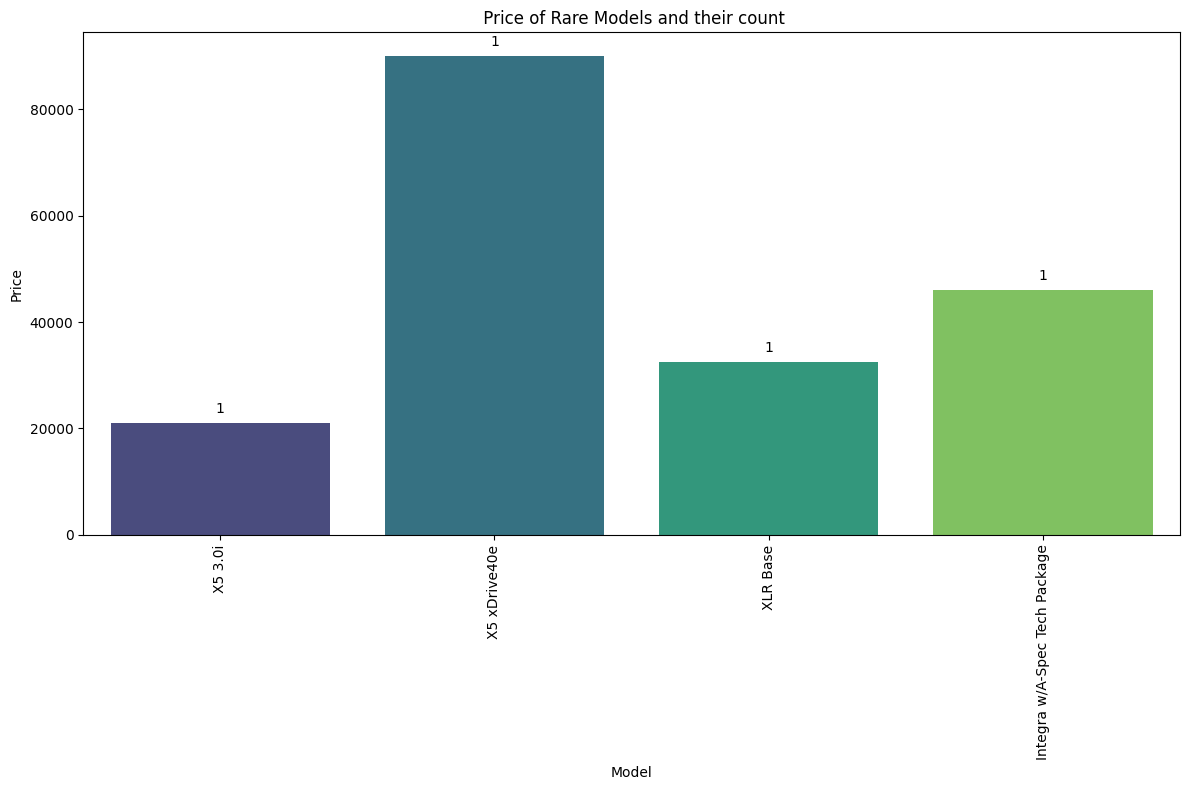

In [62]:
rare_model_price = df.groupBy('model').agg(F.sum('price').alias('total_price'), F.count('model').alias('count')).filter(F.col('count') == 1).toPandas()

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='model', y='total_price', data=rare_model_price, palette='viridis')

for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=90) 
plt.xlabel('Model')
plt.ylabel('Price')
plt.title(' Price of Rare Models and their count')
plt.tight_layout()
plt.show()


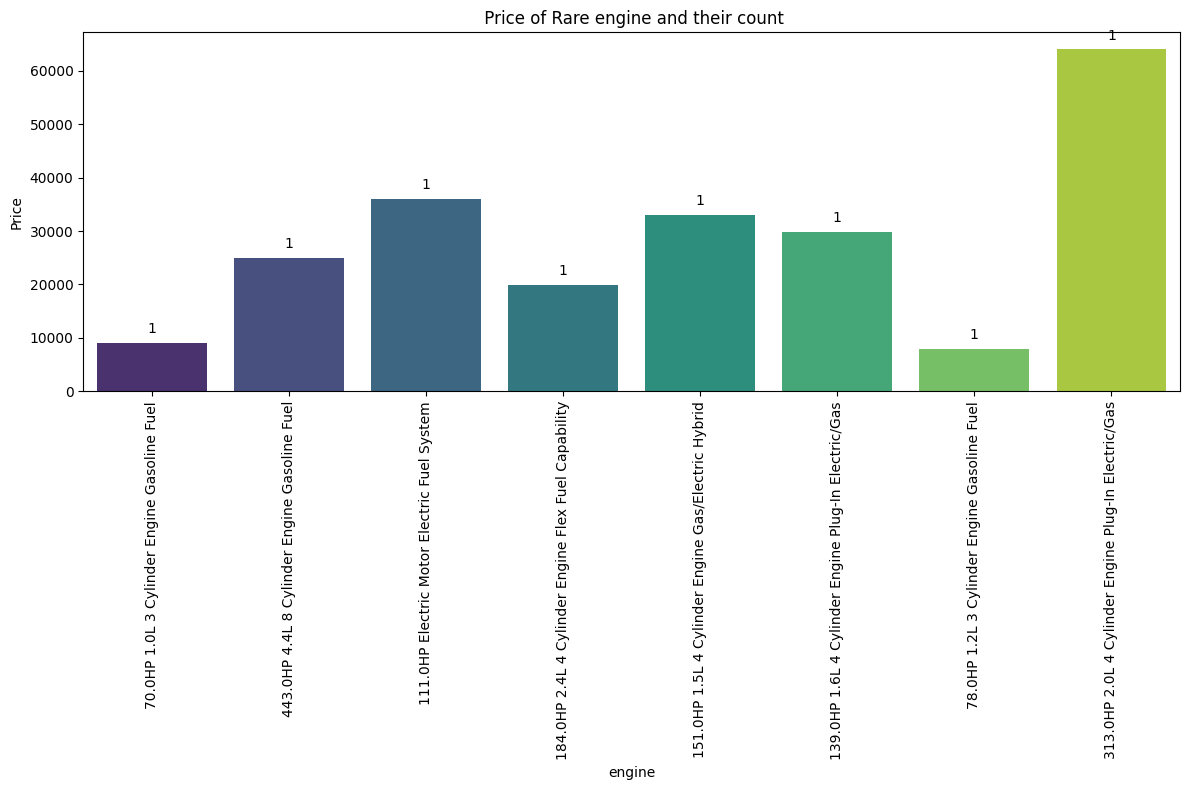

In [63]:
rare_engine_price = df.groupBy('engine').agg(F.sum('price').alias('total_price'), F.count('engine').alias('count')).filter(F.col('count') == 1).toPandas()

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='engine', y='total_price', data=rare_engine_price, palette='viridis')

for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.xticks(rotation=90) 
plt.xlabel('engine')
plt.ylabel('Price')
plt.title(' Price of Rare engine and their count')
plt.tight_layout()
plt.show()
